In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision.models import vgg16
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Download and save the model (do this once)
#preTrainModel = torchvision.models.vgg16(pretrained=True)
#torch.save(preTrainModel.state_dict(), "vgg16_pretrained.pth")

# Load the model from the saved file
modelLung = torchvision.models.vgg16()
modelLung.load_state_dict(torch.load("vgg16_pretrained.pth"))

<All keys matched successfully>

In [3]:
data_dir = "LungCT"
img_size = (224, 224)
batch_size = 64
epochs = 50
learning_rate = 0.0001

In [4]:
transform_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Load dataset
train_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform_train)
val_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform_val)

In [6]:
lb = LabelBinarizer()
labels_encoded = lb.fit_transform(train_dataset.classes)  # Use classes from train_dataset

In [8]:
# Create the full dataset first
full_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform_val)

# First split: separate test set (10% of data)
train_val_indices, test_indices = train_test_split(
    range(len(full_dataset)),
    test_size=0.1,  # 10% for test set
    random_state=42
)

# Second split: separate train and validation sets (90% of remaining data)
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.1111,  # ~10% of original data
    random_state=42
)

# Create dataset subsets using indices
from torch.utils.data import Subset
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# Freeze the convolutional base
for param in modelLung.features.parameters():
    param.requires_grad = False

In [11]:
# Modify the classifier
num_ftrs = modelLung.classifier[6].in_features
modelLung.classifier[6] = nn.Linear(num_ftrs, labels_encoded.shape[1])

In [12]:
# Define optimizer and loss function
optimizer = optim.Adam(modelLung.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [13]:
# Use GPU if available
device = torch.device("cuda:0")
modelLung.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    modelLung.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = modelLung(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    # Calculate average training loss and accuracy for the epoch
    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_accuracy = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_train_loss}, Train Accuracy: {epoch_train_accuracy}")

    # Validation
    modelLung.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = modelLung(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    # Calculate average validation loss and accuracy for the epoch
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_accuracy}")


Epoch 1/50, Loss: 0.6695607953211841, Train Accuracy: 0.753384912959381
Epoch 1/50, Validation Loss: 0.5160379012425741, Validation Accuracy: 0.8846153846153846
Epoch 2/50, Loss: 0.19480399009497726, Train Accuracy: 0.925531914893617
Epoch 2/50, Validation Loss: 0.39340608815352124, Validation Accuracy: 0.8846153846153846
Epoch 3/50, Loss: 0.153893099659506, Train Accuracy: 0.9400386847195358
Epoch 3/50, Validation Loss: 0.25646353761355084, Validation Accuracy: 0.9461538461538461
Epoch 4/50, Loss: 0.07201072738012847, Train Accuracy: 0.9816247582205029
Epoch 4/50, Validation Loss: 0.1703928808371226, Validation Accuracy: 0.9461538461538461
Epoch 5/50, Loss: 0.0703264994218069, Train Accuracy: 0.9700193423597679
Epoch 5/50, Validation Loss: 0.15858713537454605, Validation Accuracy: 0.9846153846153847
Epoch 6/50, Loss: 0.03237928359714501, Train Accuracy: 0.9893617021276596
Epoch 6/50, Validation Loss: 0.22170836695780358, Validation Accuracy: 0.9846153846153847
Epoch 7/50, Loss: 0.0124

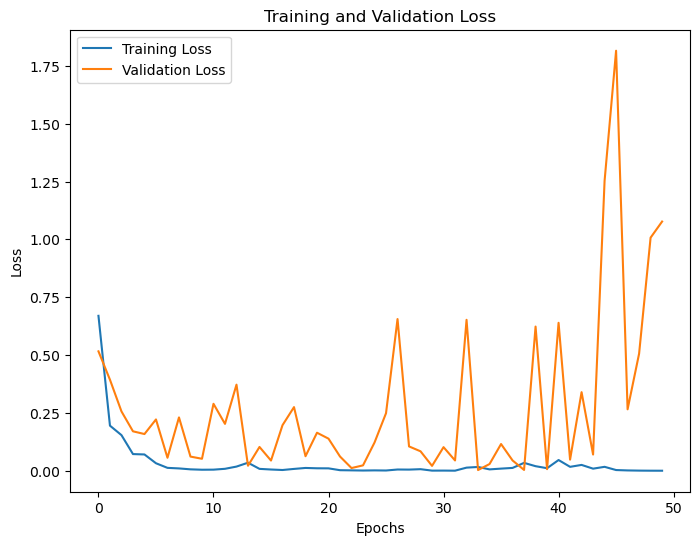

In [15]:
# Plot loss curves
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


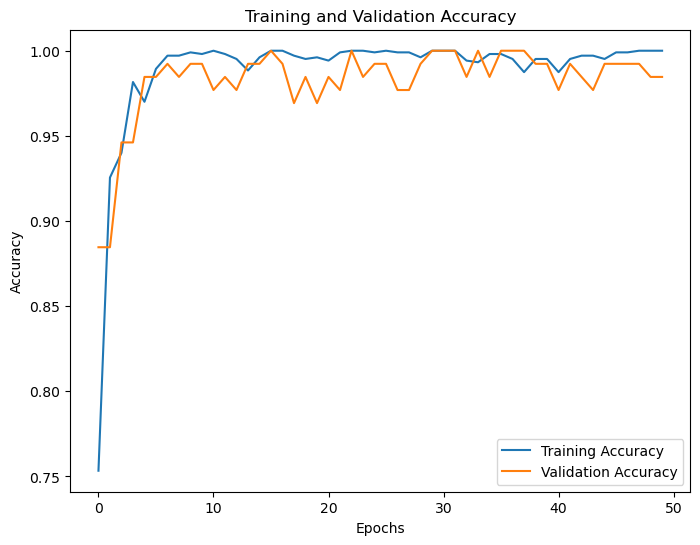

In [16]:
# Plot accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ... (model training and validation)

# Evaluate on the test set
modelLung.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:  # Assuming `test_loader` is your DataLoader for the test set
        images, labels = data[0].to(device), data[1].to(device)
        outputs = modelLung(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Test Accuracy: 0.9769230769230769
Precision: 0.9785714285714286
Recall: 0.9769230769230769
F1-score: 0.976068376068376


In [ ]:
torch.save(modelLung.state_dict(), "vgg16_lung_cancer_model_pytorch.pth")